In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
from bs4 import BeautifulSoup

In [104]:
df = pd.read_csv('./data/data.csv', low_memory=False)

In [27]:
df.shape

(29053, 142)

## Null values

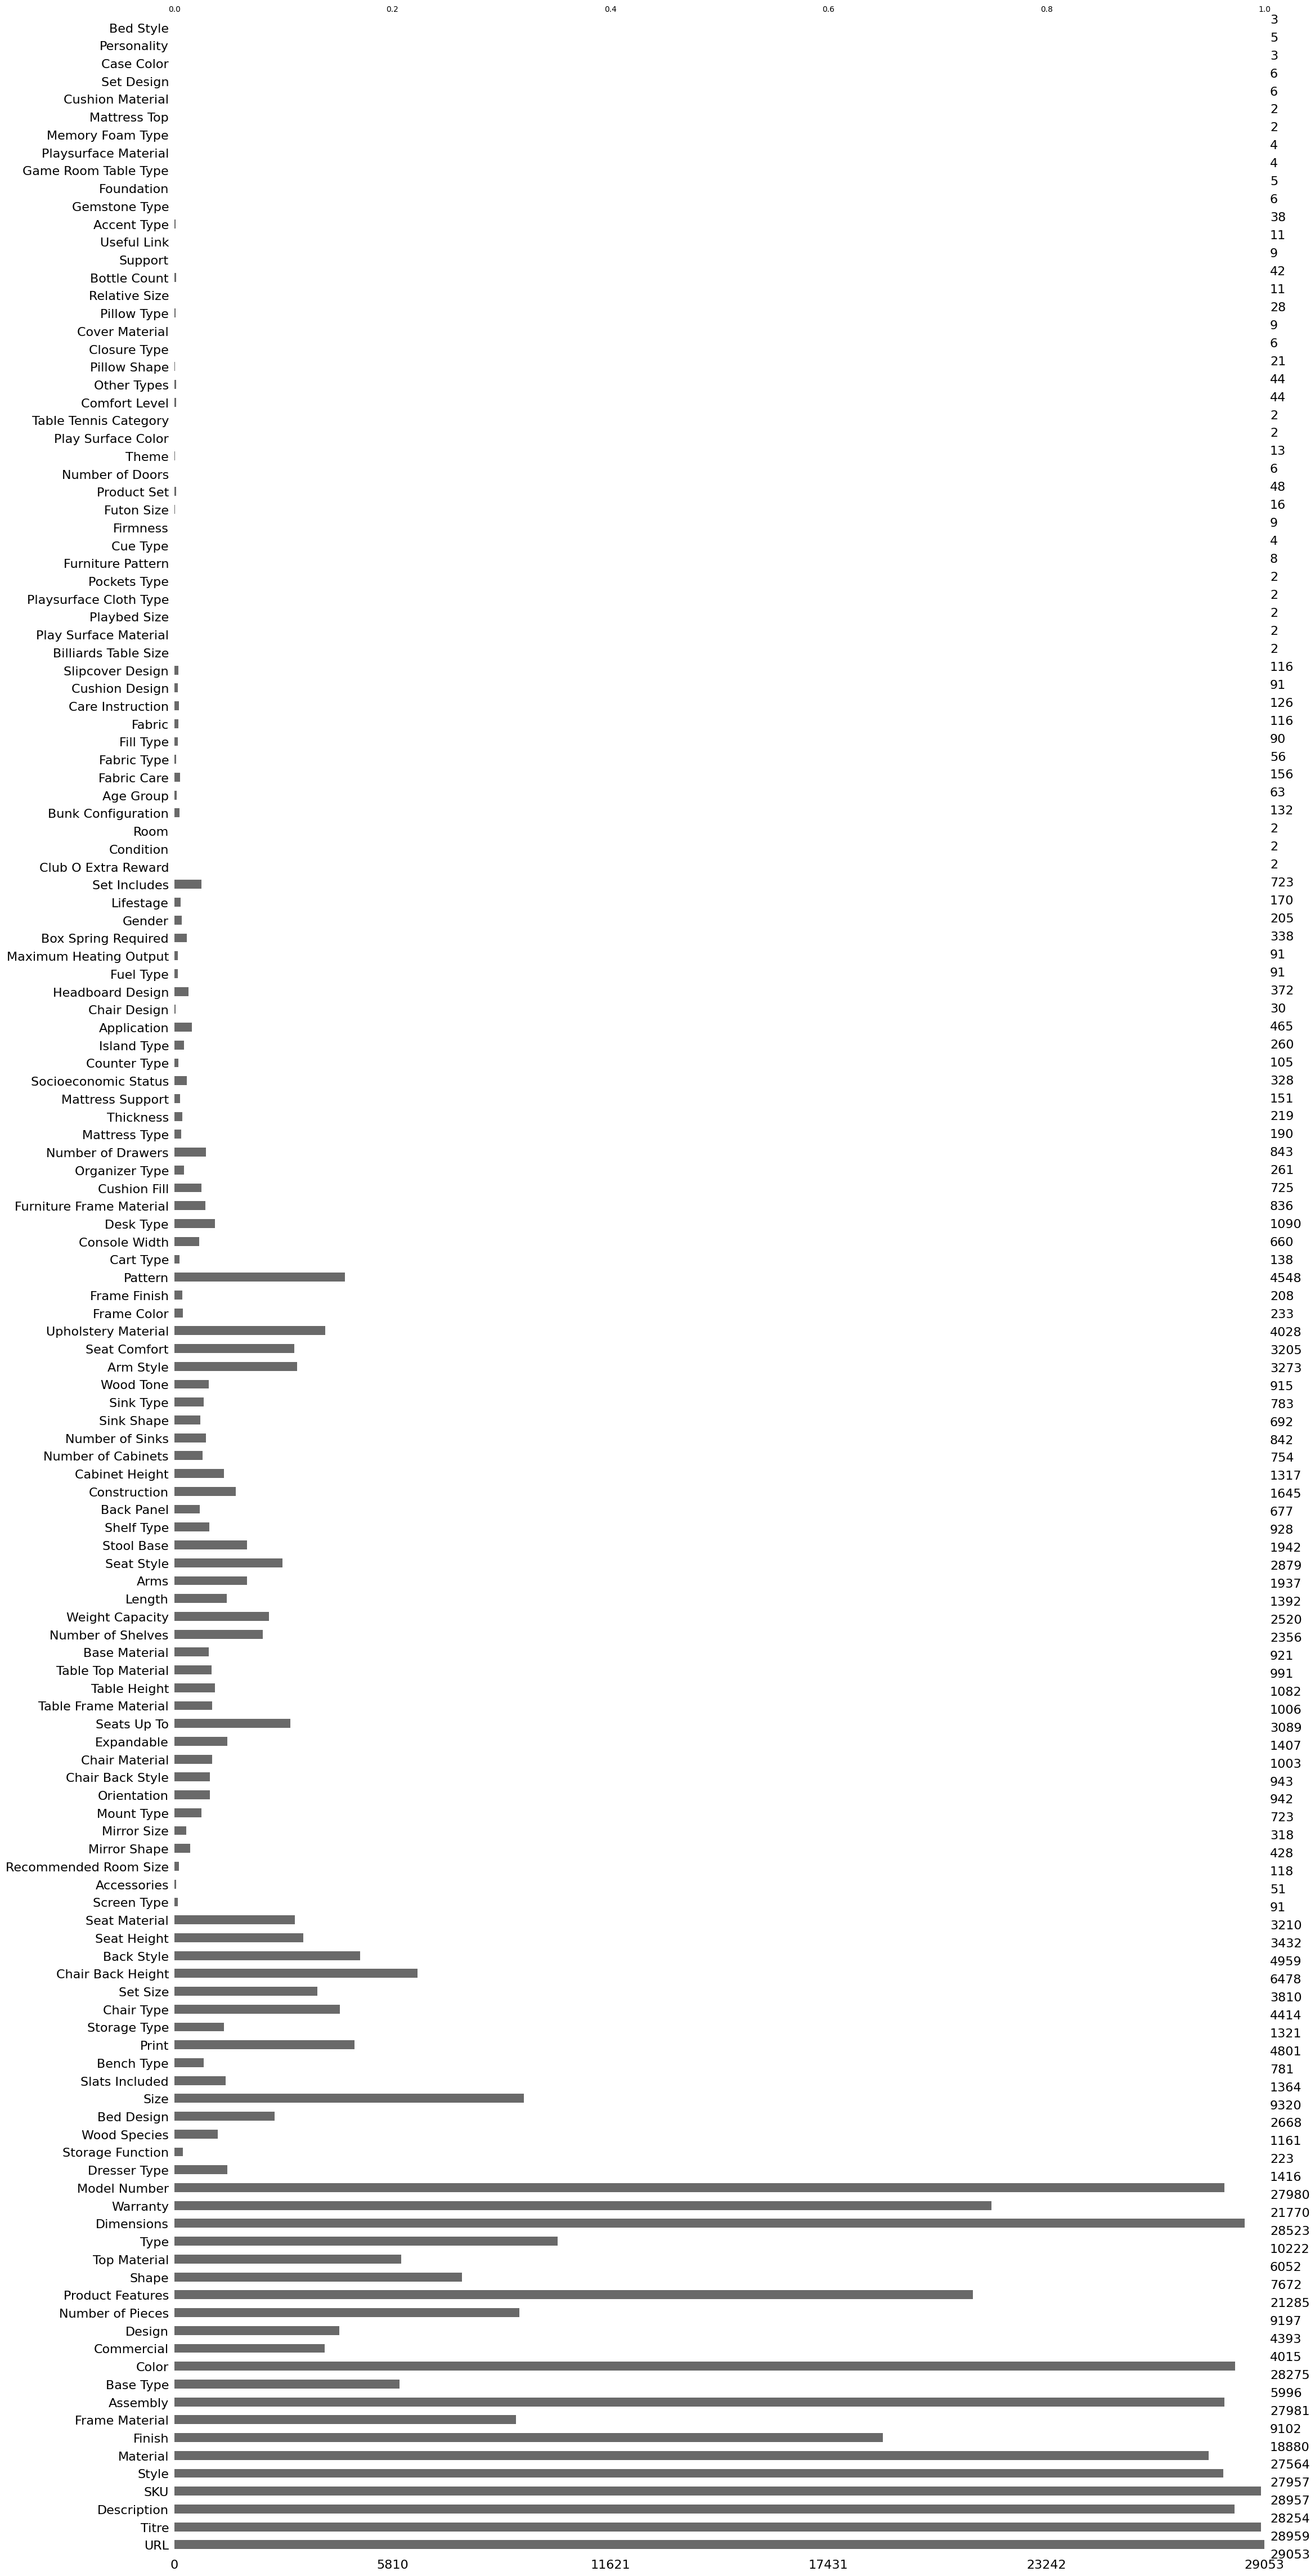

In [28]:
msno.bar(df);

In [105]:
df_clean = df.loc[:, df.isnull().mean() <= 0.5]
print(f"shape = {df_clean.shape}")
df_clean.columns.to_list()

shape = (29053, 13)


['URL',
 'Titre',
 'Description',
 'SKU',
 'Style',
 'Material',
 'Finish',
 'Assembly',
 'Color',
 'Product Features',
 'Dimensions',
 'Warranty',
 'Model Number']

In [106]:
df_clean.head(1)

,URL,Titre,Description,SKU,Style,Material,Finish,Assembly,Color,Product Features,Dimensions,Warranty,Model Number
0,https://www.overstock.com/products/39-inch-ind...,39-Inch Industrial Console Entryway Table Smal...,"Expertly crafted, this console table featuring...",42838838-000-000,"Industrial,\n M...","MDF,\n Metal",Wood Finish,Assembly Required,Brown,"Includes Hardware,\n ...",39.37 In. L X 11.81 In. W X 31.5 In. H,180 day Limited Distributor,W-YZ-JW0626


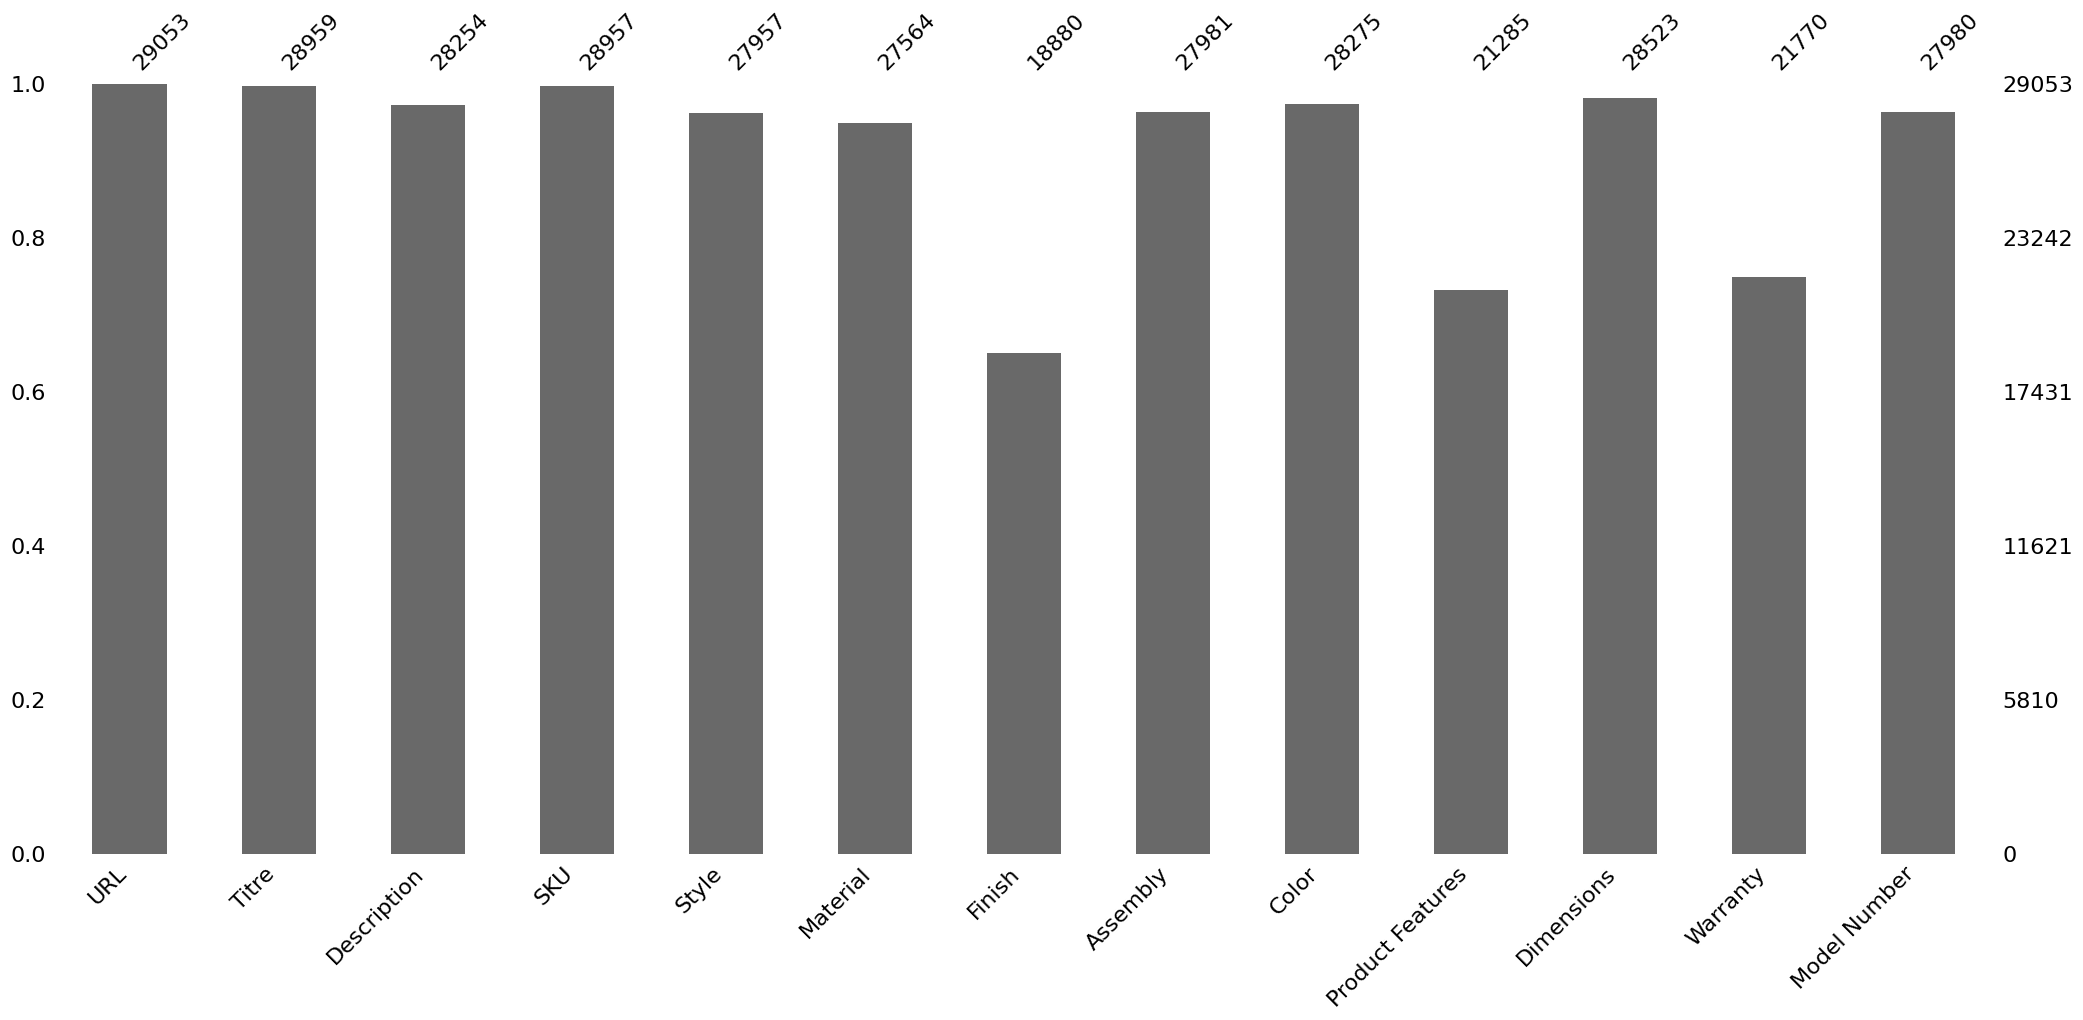

In [107]:
msno.bar(df_clean);

## Clean texts

In [110]:
df_clean.columns.to_list()

['URL',
 'Titre',
 'Description',
 'SKU',
 'Style',
 'Material',
 'Finish',
 'Assembly',
 'Color',
 'Product Features',
 'Dimensions',
 'Warranty',
 'Model Number']

In [111]:
df_clean_text = df_clean.copy()

def clean_html(text):
    if pd.isna(text):
        return text
    if text:
        return BeautifulSoup(text, "html.parser").get_text()
    return text


cols = [ 'Titre',
        'Description',
        'SKU',
        'Style',
        'Material',
        'Finish',
        'Assembly',
        'Color',
        'Product Features',
        'Dimensions']

for col in cols:
    df_clean_text[col] = df_clean[col].str.replace(r',\W*', ',', regex=True)
    df_clean_text[col] = df_clean[col].str.replace(r'[^a-zA-Z0-9,\s]', '', regex=True)
    df_clean_text[col] = df_clean[col].str.replace(r'\s{2,}', ' ', regex=True)
    df_clean_text[col] = df_clean[col].str.strip()
    df_clean_text[col] = df_clean[col].str.replace(r'\n+', ' ', regex=True)
    df_clean_text[col] = df_clean[col].str.replace(r'\s*([.,;:!?])\s*', r'\1 ', regex=True)
    df_clean_text[col] = df_clean[col].str.replace(r'\s+', ' ', regex=True)
    df_clean_text[col] = df_clean[col].apply(clean_html)

df_clean_text.head()

,URL,Titre,Description,SKU,Style,Material,Finish,Assembly,Color,Product Features,Dimensions,Warranty,Model Number
0,https://www.overstock.com/products/39-inch-ind...,39-Inch Industrial Console Entryway Table Smal...,"Expertly crafted, this console table featuring...",42838838-000-000,"Industrial,\n M...","MDF,\n Metal",Wood Finish,Assembly Required,Brown,"Includes Hardware,\n ...",39.37 In. L X 11.81 In. W X 31.5 In. H,180 day Limited Distributor,W-YZ-JW0626
1,https://www.overstock.com/products/palace-impo...,Palace Imports 100% Solid Wood Single Wardrobe...,Add even more organization to your ample Famil...,16612403-000-002,Modern & Contemporary,"Pine,\n Wood","Satin,\n Stained",Assembled,"Black,\n Brown,...","Includes Hardware,\n ...",18.0 In. W X 0.75 In. H X 28.0 In. D,1 year Limited Distributor,5657
2,https://www.overstock.com/products/boyd-sleep-...,"Boyd Sleep Lugano Wood Platform Bed Frame, Mod...",The Boyd Sleep Lugano Platform Bed Frame is a ...,43552956-000-000,Modern & Contemporary,Wood,Natural,Assembly Required,"Black,\n White",Includes Hardware,78.15 In. L X 56.5 In. W X 11.81 In. H,1 year Limited Manufacturer,LUGQNWH
3,https://www.overstock.com/products/origins-by-...,Origins by Alpine Nova Bench,Introducing the Nova Bench. This bench comes f...,39036109-000-001,Transitional,Mahogany,Honey Finish,Assembled,Brown,Storage,15.0 In. L X 59.0 In. W X 18.0 In. H,1 year Limited Manufacturer,110-12
4,https://www.overstock.com/products/kitchen-din...,Kitchen Dining Room Chairs Modern Dining Table...,Surround your dining space with a set of dinin...,44424374-000-001,Modern & Contemporary,Leather,Metal Finish,Assembly Required,"Beige,\n Black,...",Water Resistant,19.69 In. W X 31.5 In. H X 24.02 In. D,3 year Limited Manufacturer,1946-Bean-Green


## Imputation

**Imputation des colonne à ratrit du titre et du description**

In [150]:
df_clean_text.columns.to_list()

['URL',
 'Titre',
 'Description',
 'SKU',
 'Style',
 'Material',
 'Finish',
 'Assembly',
 'Color',
 'Product Features',
 'Dimensions',
 'Warranty',
 'Model Number']

In [212]:
df_base = df_clean_text
df_imp = df_base.copy()


def normalize(text):
    return re.sub(r"\W+", " ", str(text)).lower().strip()


def impute_col(row, col, tokens):
    titre = str(row["Titre"]) if not pd.isnull(row["Titre"]) else ""
    description = str(row["Description"]) if not pd.isnull(row["Description"]) else ""

    if not titre and not description:
        return row[col]  # nothing to use for imputation

    text = normalize(f"{titre} {description}")
    text_words = set(text.split())

    matches = tokens.intersection(text_words)
    if matches:
        return list(matches)[0]  # choose first match
    return row[col]


cols = [
    "SKU",
    "Style",
    "Material",
    "Finish",
    "Assembly",
    "Color",
    "Product Features",
    "Dimensions",
]

for col in cols:
    # print(f"Processing column: {col}")
    unique_values = (
        df_base[col]
        .dropna()
        .astype(str)
        .str.split(",", expand=True)
        .stack()
        .str.strip()
        .unique()
    )

    tokens = {normalize(val) for val in unique_values}

    before = df_base[col].isnull().sum()
    df_imp[col] = df_imp.apply(lambda row: impute_col(row, col, tokens), axis=1)
    after = df_imp[col].isnull().sum()

In [213]:
pd.concat([df_base.isnull().sum(), df_imp.isnull().sum()], axis=1).rename(
    columns={0: 'Before', 1: 'After'}).where(
    lambda x: x['Before'] != x['After']).dropna().astype(int)

,Before,After
Style,1096,884
Material,1489,482
Finish,10173,6602
Assembly,1072,1047
Color,778,568
Product Features,7768,3024


#### Dimensions
Impute dimentions that has 'See Description' with mode

In [232]:
df_imp['Dimensions'].where(lambda x: x.str.contains(
    r'^[a-zA-Z\s]+$', na=False, regex=True)).dropna()

24       See Description
27       See Description
39       See Description
45       See Description
56       See Description
              ...       
29026    See Description
29035    See Description
29036    See Description
29038    See Description
29042    See Description
Name: Dimensions, Length: 4863, dtype: object

In [242]:
from sklearn.impute import SimpleImputer

df_imp_dim = df_imp.copy()

# Mask for rows where Dimensions contains only letters and spaces
# mask = df_imp['Dimensions'].str.contains(r'^[a-zA-Z\s]+$', na=False)

mask = (
    df_imp['Dimensions'].isna() |
    df_imp['Dimensions'].str.contains(r'^[a-zA-Z\s]+$', na=False)
)

# Imputer setup
imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation only on the masked rows
imputed_values = imputer.fit_transform(df_imp.loc[~mask, ['Dimensions']]).ravel()

# Replace the masked (invalid) values with the most frequent value
df_imp_dim.loc[mask, 'Dimensions'] = imputed_values[0]

print(df_imp_dim['Dimensions'].isnull().sum())

0


## Drop columns

In [244]:
cols = ['Model Number', 'SKU', 'URL', 'Titre', 'Warranty']
df_drop_cols = df_imp_dim.drop(columns=cols)
print(df_drop_cols.shape)
df_drop_cols.head(0)

(29053, 8)


,Description,Style,Material,Finish,Assembly,Color,Product Features,Dimensions


## Null values

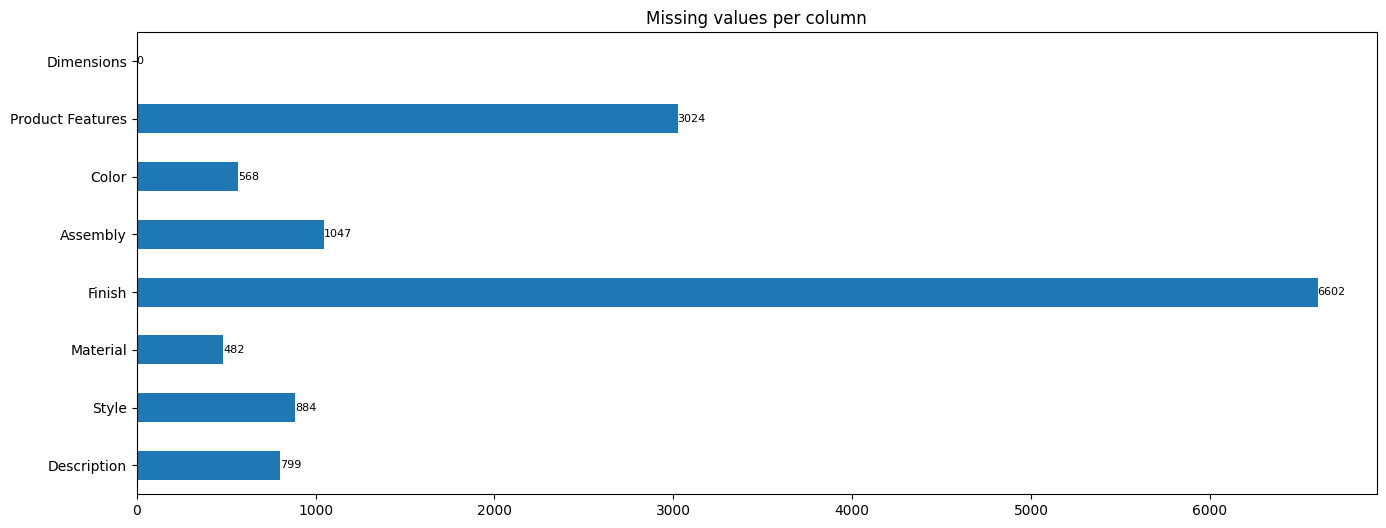

In [251]:
df_drop_cols.isna().sum().to_frame().plot(kind='barh', legend=False, figsize=(16, 6))
for index, value in enumerate(df_drop_cols.isna().sum()):
    plt.text(value, index,
             str(value), va='center', ha='left', fontsize=8)
plt.title("Missing values per column");

In [252]:
# drop all nulls
df_drop_nulls = df_drop_cols.dropna(how='any')
print(df_drop_nulls.shape)
print(df_drop_nulls.isna().sum().sum())

(18640, 8)
0


## Description

In [253]:
# remove all description that has a length < 50 characters
df_clean_desc_1 = df_drop_nulls[df_drop_nulls['Description'].fillna('').str.len() >= 50]
df_clean_desc_1.shape

(17549, 8)

In [248]:
# remove all description that begin with the word 'warning' using regex without case sensitivity
df_clean_desc_2 = df_clean_desc_1[~df_clean_desc_1['Description'].str.match(r'warning', case=False, na=False)]
df_clean_desc_2.shape

(15989, 8)

## Tmp saving data

In [254]:
tmp_df = df_clean_desc_2.dropna()
print(tmp_df.shape)
tmp_df.to_csv('data/data_cleaned.csv', index=False)

(15989, 8)
